In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\user\anaconda3\lib\site-packages (2.2.2)



In [7]:
import pandas as pd

# Load dataset
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

# Convert InvoiceDate correctly
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')

# Quick look
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Drop rows with missing values
df = df.dropna()

# Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Focus on one country (United Kingdom, since it has most records)
df = df[df['Country'] == "United Kingdom"]

# Quick check
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 354321 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354321 non-null  object 
 1   StockCode    354321 non-null  object 
 2   Description  354321 non-null  object 
 3   Quantity     354321 non-null  int64  
 4   InvoiceDate  354321 non-null  object 
 5   UnitPrice    354321 non-null  float64
 6   CustomerID   354321 non-null  float64
 7   Country      354321 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
import datetime as dt

# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Define reference date (day after the last invoice)
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',   # Frequency
    'TotalPrice': 'sum'       # Monetary
})

# Rename columns
rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalPrice':'Monetary'}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [9]:
from sklearn.preprocessing import StandardScaler

# Select RFM features
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]  # preview

array([[ 2.32202285, -0.32936215, -0.23100099],
       [-0.89373323,  0.20610242,  0.29343167],
       [-0.1691956 , -0.11517632, -0.01231622],
       [-0.72500529, -0.43645506, -0.01714563],
       [ 2.16322008, -0.43645506, -0.19031183]])

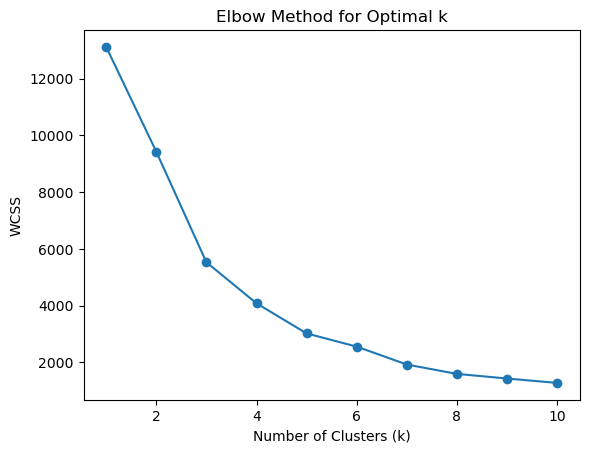

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try different k values
wcss = []  # within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()


In [11]:
# Train KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,2,0.00,1
12347.0,2,7,4310.00,3
12348.0,75,4,1797.24,3
12349.0,19,1,1757.55,3
12350.0,310,1,334.40,1


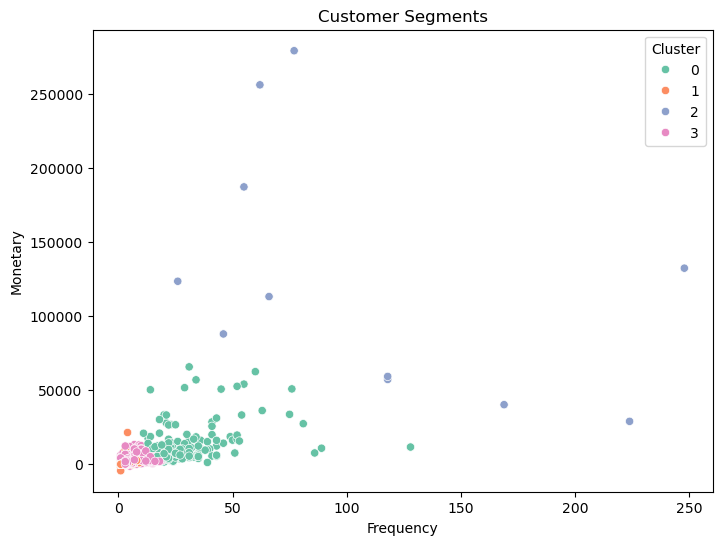

In [12]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="Set2")
plt.title("Customer Segments")
plt.show()